## Import required libraries

In [5]:
from scipy.io.arff import loadarff
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, matthews_corrcoef

import warnings
warnings.filterwarnings("ignore")

## Load dataset

In [6]:
raw_data = loadarff("./dataset/PC2.arff")
data = pd.DataFrame(raw_data[0])
data['Defective'] = data['Defective'].apply(lambda x: 1 if x.decode() == 'Y' else 0)
data.head()

,BRANCH_COUNT,CALL_PAIRS,LOC_CODE_AND_COMMENT,LOC_COMMENTS,CONDITION_COUNT,CYCLOMATIC_COMPLEXITY,CYCLOMATIC_DENSITY,DECISION_COUNT,DECISION_DENSITY,DESIGN_COMPLEXITY,...,NODE_COUNT,NORMALIZED_CYLOMATIC_COMPLEXITY,NUM_OPERANDS,NUM_OPERATORS,NUM_UNIQUE_OPERANDS,NUM_UNIQUE_OPERATORS,NUMBER_OF_LINES,PERCENT_COMMENTS,LOC_TOTAL,Defective
0,3.0,2.0,2.0,5.0,4.0,2.0,0.67,2.0,2.0,2.0,...,6.0,0.20,2.0,7.0,2.0,6.0,10.0,87.50,3.0,0
1,3.0,1.0,0.0,0.0,4.0,2.0,1.00,2.0,2.0,2.0,...,5.0,2.00,2.0,8.0,2.0,8.0,1.0,0.00,0.0,0
2,7.0,5.0,10.0,1.0,12.0,4.0,0.31,6.0,2.0,4.0,...,23.0,0.25,26.0,49.0,9.0,17.0,16.0,78.57,13.0,0
3,7.0,4.0,9.0,1.0,12.0,4.0,0.33,6.0,2.0,4.0,...,18.0,0.24,26.0,37.0,13.0,17.0,17.0,76.92,12.0,0
4,7.0,2.0,21.0,1.0,12.0,4.0,0.16,6.0,2.0,2.0,...,13.0,0.14,40.0,46.0,14.0,15.0,29.0,84.62,25.0,0


In [7]:
def MCC(yt,yp):
    tn, fp, fn, tp = confusion_matrix(yt, yp).ravel()
    #print(confusion_matrix(yt, yp))
    den=(tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)
    if den==0:
        den=1
    return (tp*tn-fp*fn)/den**0.5

## Model Training and Testing without Feature Selection

In [8]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10)

### K-Nearest Neighbour

In [9]:
knn = KNeighborsClassifier(n_neighbors = 89)
knn.fit(X_train, y_train)
print(f"Score: {knn.score(X_test, y_test)}")
y_pred=knn.predict(X_test)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.9866071428571429
MCC: 0.0


### Naive Bayes

In [10]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
print(f"Score: {gnb.score(X_test, y_test)}")
y_pred=gnb.predict(X_test)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.9330357142857143
MCC: 0.13035898147917382


### Decision Tree

In [11]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
print(f"Score: {dtc.score(X_test, y_test)}")
y_pred=dtc.predict(X_test)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.96875
MCC: -0.015710251796769326


### Random Forest

In [12]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
print(f"Score: {rfc.score(X_test, y_test)}")
y_pred=rfc.predict(X_test)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.9866071428571429
MCC: 0.0


### AdaBoost

In [13]:
abc = AdaBoostClassifier()
abc.fit(X_train, y_train)
print(f"Score: {abc.score(X_test, y_test)}")
y_pred=abc.predict(X_test)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.9642857142857143
MCC: -0.01760465162266343


## Correlation Matrix of Dataset

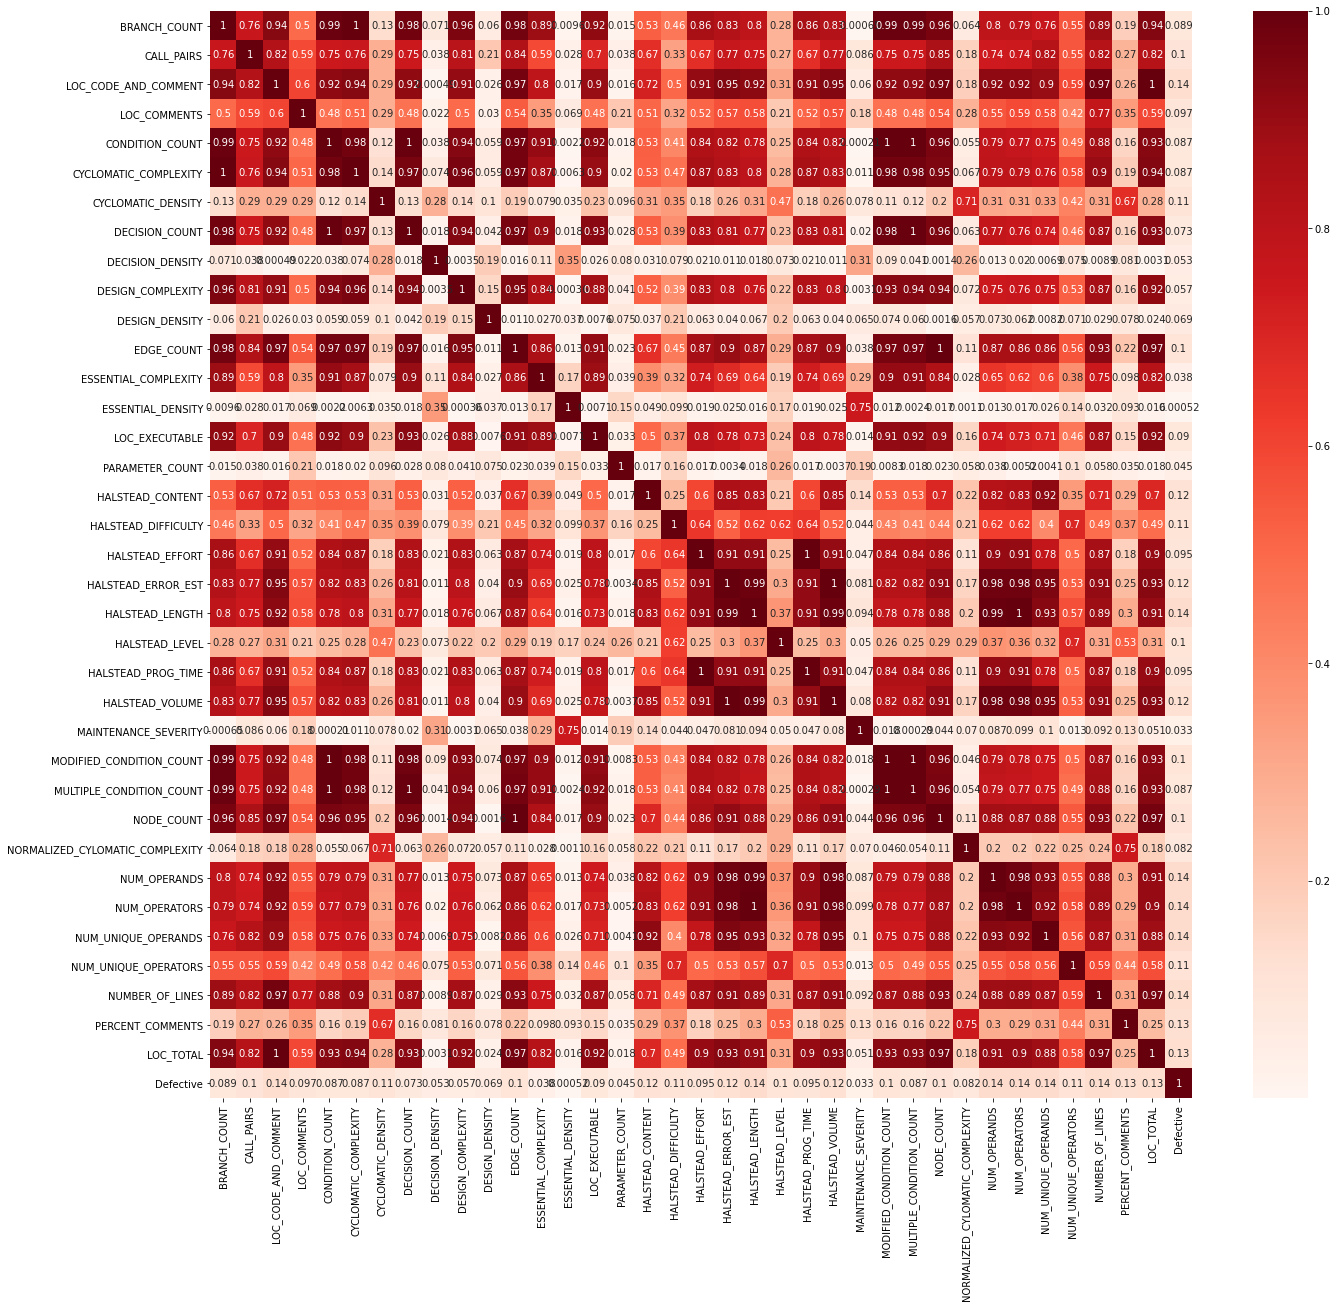

In [14]:
correlation_matrix = data.corr().abs()
plt.figure(figsize = (22, 20))
sns.heatmap(correlation_matrix, annot = True, cmap = plt.cm.Reds)
plt.show()

## Model training and testing with Hybrid Feature Selection

In [15]:
upper_triangular_matrix = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k = 1).astype(bool))
features_to_drop = [column for column in upper_triangular_matrix.columns if any(upper_triangular_matrix[column] > 0.95)]
print("Features to drop: ", features_to_drop)
data = data.drop(features_to_drop, axis = 1)
data.head()

Features to drop:  ['CONDITION_COUNT', 'CYCLOMATIC_COMPLEXITY', 'DECISION_COUNT', 'DESIGN_COMPLEXITY', 'EDGE_COUNT', 'HALSTEAD_LENGTH', 'HALSTEAD_PROG_TIME', 'HALSTEAD_VOLUME', 'MODIFIED_CONDITION_COUNT', 'MULTIPLE_CONDITION_COUNT', 'NODE_COUNT', 'NUM_OPERANDS', 'NUM_OPERATORS', 'NUM_UNIQUE_OPERANDS', 'NUMBER_OF_LINES', 'LOC_TOTAL']


,BRANCH_COUNT,CALL_PAIRS,LOC_CODE_AND_COMMENT,LOC_COMMENTS,CYCLOMATIC_DENSITY,DECISION_DENSITY,DESIGN_DENSITY,ESSENTIAL_COMPLEXITY,ESSENTIAL_DENSITY,LOC_EXECUTABLE,...,HALSTEAD_CONTENT,HALSTEAD_DIFFICULTY,HALSTEAD_EFFORT,HALSTEAD_ERROR_EST,HALSTEAD_LEVEL,MAINTENANCE_SEVERITY,NORMALIZED_CYLOMATIC_COMPLEXITY,NUM_UNIQUE_OPERATORS,PERCENT_COMMENTS,Defective
0,3.0,2.0,2.0,5.0,0.67,2.0,1.0,1.0,0.0,1.0,...,9.00,3.00,81.00,0.01,0.33,0.50,0.20,6.0,87.50,0
1,3.0,1.0,0.0,0.0,1.00,2.0,1.0,1.0,0.0,0.0,...,8.30,4.00,132.88,0.01,0.25,0.50,2.00,8.0,0.00,0
2,7.0,5.0,10.0,1.0,0.31,2.0,1.0,1.0,0.0,3.0,...,14.36,24.56,8656.64,0.12,0.04,0.25,0.25,17.0,78.57,0
3,7.0,4.0,9.0,1.0,0.33,2.0,1.0,1.0,0.0,3.0,...,18.18,17.00,5255.28,0.10,0.06,0.25,0.24,17.0,76.92,0
4,7.0,2.0,21.0,1.0,0.16,2.0,0.5,4.0,1.0,4.0,...,19.50,21.43,8952.56,0.14,0.05,1.00,0.14,15.0,84.62,0


In [16]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10)

### K-Nearest Neighbour

In [18]:
knn = KNeighborsClassifier(n_neighbors=89)
sfs = SequentialFeatureSelector(knn)
X_train_sfs = sfs.fit_transform(X_train, y_train)
X_test_sfs = sfs.transform(X_test)
knn.fit(X_train_sfs, y_train)
print(f"Score: {knn.score(X_test_sfs, y_test)}")
y_pred=knn.predict(X_test_sfs)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.9866071428571429
MCC: 0.0


Selected features for KNN

In [19]:
selected_features_index = sfs.get_support(True)
data.columns[selected_features_index]

Index(['BRANCH_COUNT', 'CALL_PAIRS', 'LOC_CODE_AND_COMMENT', 'LOC_COMMENTS',
       'CYCLOMATIC_DENSITY', 'DECISION_DENSITY', 'DESIGN_DENSITY',
       'ESSENTIAL_COMPLEXITY', 'ESSENTIAL_DENSITY', 'LOC_EXECUTABLE'],
      dtype='object')

### Naive Bayes

In [20]:
gnb = GaussianNB()
sfs = SequentialFeatureSelector(gnb)
X_train_sfs = sfs.fit_transform(X_train, y_train)
X_test_sfs = sfs.transform(X_test)
gnb.fit(X_train_sfs, y_train)
print(f"Score: {gnb.score(X_test_sfs, y_test)}")
y_pred=gnb.predict(X_test_sfs)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.9553571428571429
MCC: -0.020925875812005792


Selected Features for Naive Bayes

In [21]:
selected_features_index = sfs.get_support(True)
data.columns[selected_features_index]

Index(['CALL_PAIRS', 'LOC_COMMENTS', 'CYCLOMATIC_DENSITY', 'DECISION_DENSITY',
       'DESIGN_DENSITY', 'ESSENTIAL_DENSITY', 'LOC_EXECUTABLE',
       'PARAMETER_COUNT', 'HALSTEAD_DIFFICULTY', 'MAINTENANCE_SEVERITY'],
      dtype='object')

### Decision Tree

In [22]:
dtc = DecisionTreeClassifier()
sfs = SequentialFeatureSelector(dtc)
X_train_sfs = sfs.fit_transform(X_train, y_train)
X_test_sfs = sfs.transform(X_test)
dtc.fit(X_train_sfs, y_train)
print(f"Score: {dtc.score(X_test_sfs, y_test)}")
y_pred=dtc.predict(X_test_sfs)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.9598214285714286
MCC: 0.1868535538878646


Selected features for Decision Tree

In [23]:
selected_features_index = sfs.get_support(True)
data.columns[selected_features_index]

Index(['BRANCH_COUNT', 'CYCLOMATIC_DENSITY', 'DECISION_DENSITY',
       'DESIGN_DENSITY', 'ESSENTIAL_COMPLEXITY', 'ESSENTIAL_DENSITY',
       'PARAMETER_COUNT', 'HALSTEAD_DIFFICULTY', 'HALSTEAD_LEVEL',
       'MAINTENANCE_SEVERITY'],
      dtype='object')

### Random Forest

In [24]:
rfc = RandomForestClassifier()
sfs = SequentialFeatureSelector(rfc)
X_train_sfs = sfs.fit_transform(X_train, y_train)
X_test_sfs = sfs.transform(X_test)
rfc.fit(X_train_sfs, y_train)
print(f"Score: {rfc.score(X_test_sfs, y_test)}")
y_pred=rfc.predict(X_test_sfs)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.9866071428571429
MCC: 0.0


Selected features for Random Forest

In [25]:
selected_features_index = sfs.get_support(True)
data.columns[selected_features_index]

Index(['BRANCH_COUNT', 'CALL_PAIRS', 'LOC_CODE_AND_COMMENT', 'LOC_COMMENTS',
       'CYCLOMATIC_DENSITY', 'DESIGN_DENSITY', 'ESSENTIAL_DENSITY',
       'HALSTEAD_CONTENT', 'HALSTEAD_EFFORT', 'HALSTEAD_LEVEL'],
      dtype='object')

### AdaBoost

In [26]:
abc = AdaBoostClassifier()
sfs = SequentialFeatureSelector(abc)
X_train_sfs = sfs.fit_transform(X_train, y_train)
X_test_sfs = sfs.transform(X_test)
abc.fit(X_train_sfs, y_train)
print(f"Score: {abc.score(X_test_sfs, y_test)}")
y_pred=abc.predict(X_test_sfs)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.96875
MCC: -0.015710251796769326


Selected features for AdaBoost Classifier

In [27]:
selected_features_index = sfs.get_support(True)
data.columns[selected_features_index]

Index(['CALL_PAIRS', 'DESIGN_DENSITY', 'ESSENTIAL_COMPLEXITY',
       'ESSENTIAL_DENSITY', 'LOC_EXECUTABLE', 'PARAMETER_COUNT',
       'HALSTEAD_LEVEL', 'MAINTENANCE_SEVERITY',
       'NORMALIZED_CYLOMATIC_COMPLEXITY', 'PERCENT_COMMENTS'],
      dtype='object')